## humidity and org - one model

In [2]:
import xarray as xr
import numpy as np
import skimage.measure as skm
import pandas as pd
import scipy

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeat

from os.path import expanduser
home = expanduser("~")

import timeit

In [3]:
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

def plot_snapshot(var, cmap, variable_name, model):
    projection = ccrs.PlateCarree(central_longitude=180)
    lat = var.lat
    lon = var.lon

    f, ax = plt.subplots(subplot_kw=dict(projection=projection), figsize=(15, 5))

    var.plot(transform=ccrs.PlateCarree(), cbar_kwargs={'orientation': 'horizontal','pad':0.125, 'aspect':50,'fraction':0.055}, cmap=cmap)
    ax.add_feature(cfeat.COASTLINE)
    ax.set_extent([lon[0], lon[-1], lat[0], lat[-1]], crs=ccrs.PlateCarree())
    ax.set_title(variable_name + ' snapshot, model:' + model)
    ax.set_xticks([-180, -90, 0, 90, 180])
    ax.set_xticklabels([0, 90, 180, 270, 360])
    ax.set_yticks([-20, 0, 20])
    plt.tight_layout()

In [4]:
models = [
    # 'IPSL-CM5A-MR', # 1
    'GFDL-CM3',     
    # 'GISS-E2-H',    # 3
    # 'bcc-csm1-1',   # 4
    # 'CNRM-CM5',     # 5
    # 'CCSM4',        # 6 # cannot concatanate files for rcp85 run
    # 'HadGEM2-AO',   # 7
    # 'BNU-ESM',      # 8
    # 'EC-EARTH',     # 9
    # 'FGOALS-g2',    # 10
    # 'MPI-ESM-MR',   # 11
    # 'CMCC-CM',      # 12
    # 'inmcm4',       # 13
    # 'NorESM1-M',    # 14
    # 'CanESM2',      # 15
    # 'MIROC5',       # 16
    # 'HadGEM2-CC',   # 17
    # 'MRI-CGCM3',    # 18
    # 'CESM1-BGC'     # 19
    ]
model = models[0]


experiments = [
    'historical',
    #'rcp85'
    ]
experiment = experiments[0]       

In [5]:
folder = home + '/Documents/data/cmip5/' + 'ds'
fileName = model + '_hus_' + experiment + '.nc'
path = folder + '/' + fileName
ds = xr.open_dataset(path)
hus = ds.hus

In [6]:
hus

<xarray.DataArray 'hus' (time: 10950, plev: 8, lat: 22, lon: 128)>
[246681600 values with dtype=float32]
Coordinates:
  * plev     (plev) float64 1e+05 8.5e+04 7e+04 5e+04 2.5e+04 1e+04 5e+03 1e+03
  * time     (time) object 1970-01-01 12:00:00 ... 1999-12-31 12:00:00
  * lat      (lat) float64 -29.3 -26.51 -23.72 -20.93 ... 20.93 23.72 26.51 29.3
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2

In [7]:
hus['plev']

<xarray.DataArray 'plev' (plev: 8)>
array([100000.,  85000.,  70000.,  50000.,  25000.,  10000.,   5000.,   1000.])
Coordinates:
  * plev     (plev) float64 1e+05 8.5e+04 7e+04 5e+04 2.5e+04 1e+04 5e+03 1e+03

In [8]:
aWeights = np.cos(np.deg2rad(hus.lat))

### mean humidity

In [9]:
pw = xr.DataArray(
    data=-scipy.integrate.simpson(hus.fillna(0), hus.plev.data, axis=1, even='last'),
    dims=['time','lat', 'lon'],
    coords={'time': hus.time.data, 'lat': hus.lat.data, 'lon': hus.lon.data},
    attrs={'units':'mm/day',
            'Description': 'precipitable water'}
    )

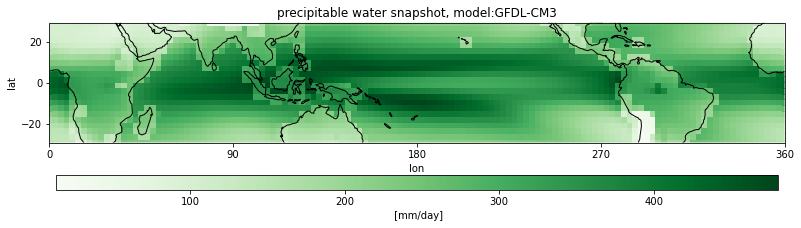

In [10]:
plot_snapshot(pw.mean(dim = 'time', keep_attrs=True), 'Greens', 'precipitable water', model)

Text(0, 0.5, 'precipitable water [mm/day]')

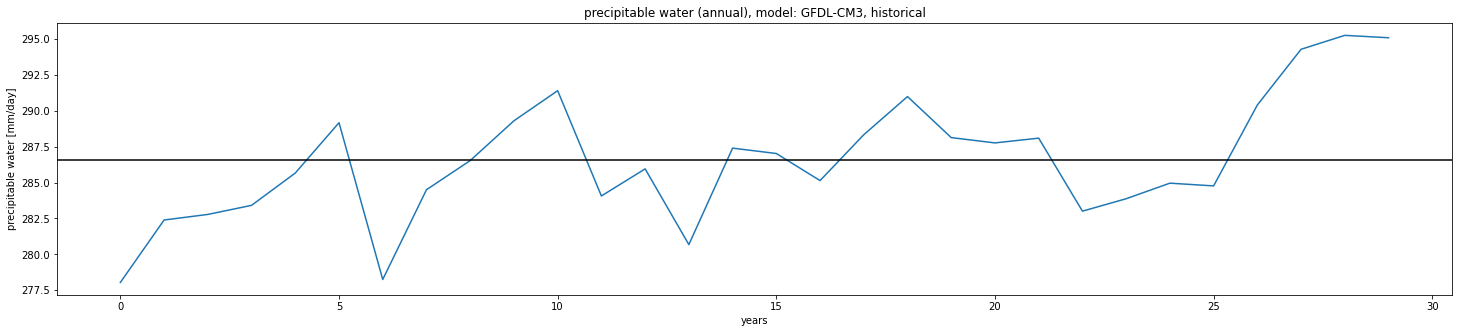

In [11]:
f, ax = plt.subplots(figsize = (25,5))
ax.plot(pw.resample(time='Y').mean(dim='time').weighted(aWeights).mean(dim=('lat','lon')))
ax.axhline(y=pw.weighted(aWeights).mean(dim=('lat','lon')).mean(dim='time'), color='k')
ax.set_title('precipitable water (annual), model: ' + model + ', ' + experiment)
ax.set_xlabel('years')
ax.set_ylabel('precipitable water [mm/day]')

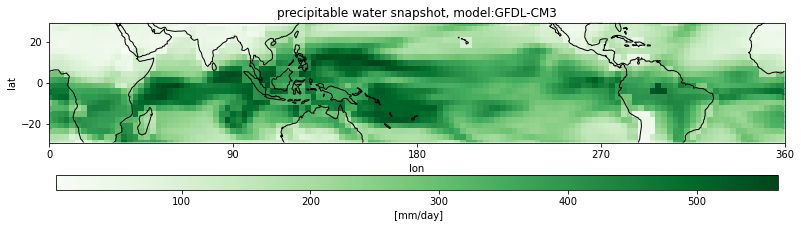

In [12]:
plot_snapshot(pw.isel(time=0), 'Greens', 'precipitable water', model)

Text(0, 0.5, 'precipitable water [mm/day]')

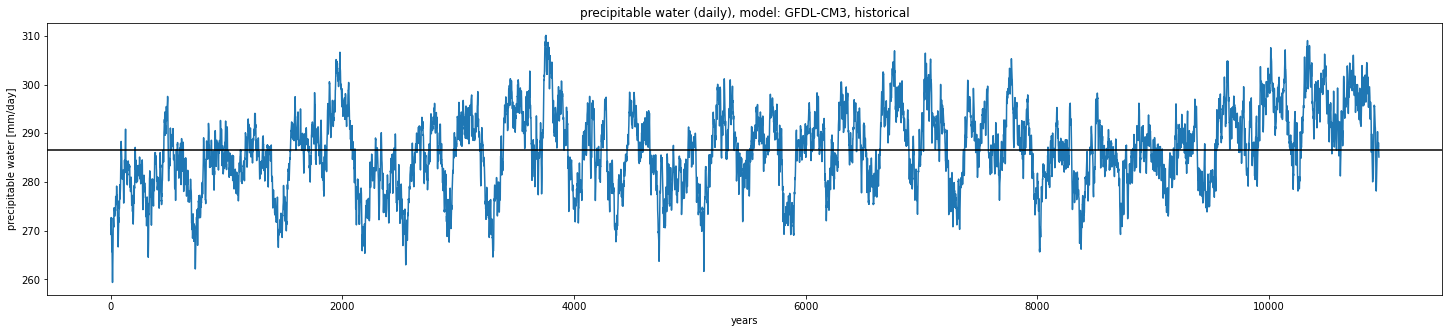

In [13]:
f, ax = plt.subplots(figsize = (25,5))
ax.plot(pw.weighted(aWeights).mean(dim=('lat','lon')))
ax.axhline(y=pw.weighted(aWeights).mean(dim=('lat','lon')).mean(dim='time'), color='k')
ax.set_title('precipitable water (daily), model: ' + model + ', ' + experiment)
ax.set_xlabel('years')
ax.set_ylabel('precipitable water [mm/day]')

In [14]:
folder = home + '/Documents/data/cmip5/' + model
fileName = model + '_rome_' + experiment + '.nc'
path = folder + '/' + fileName
rome = xr.open_dataset(path)
rome

<xarray.Dataset>
Dimensions:  (time: 10950)
Coordinates:
  * time     (time) object 1970-01-01 12:00:00 ... 1999-12-31 12:00:00
Data variables:
    rome     (time) float64 ...
    rome_n   (time) float64 ...
Attributes:
    description:  ROME based on all and the 8 largest contiguous convective r...
    units:        km^2

In [15]:
rome_options = [
    'rome',
    # 'rome_n'
    ]
rome_option = rome_options[0]

In [16]:
# da = hus.sel(plev = slice(1000e2, 500e2))
# pw_lower = xr.DataArray(
#     data=-scipy.integrate.simpson(da.fillna(0), da.plev.data, axis=1, even='last'),
#     dims=['time','lat', 'lon'],
#     coords={'time': da.time.data, 'lat': da.lat.data, 'lon': da.lon.data},
#     attrs={'units':'mm/day',
#             'Description': 'precipitable water'}
#     )

# da = hus.sel(plev = slice(500e2, 10e2))
# pw_upper = xr.DataArray(
#     data=-scipy.integrate.simpson(da.fillna(0), da.plev.data, axis=1, even='last'),
#     dims=['time','lat', 'lon'],
#     coords={'time': da.time.data, 'lat': da.lat.data, 'lon': da.lon.data},
#     attrs={'units':'mm/day',
#             'Description': 'precipitable water'}
#     )

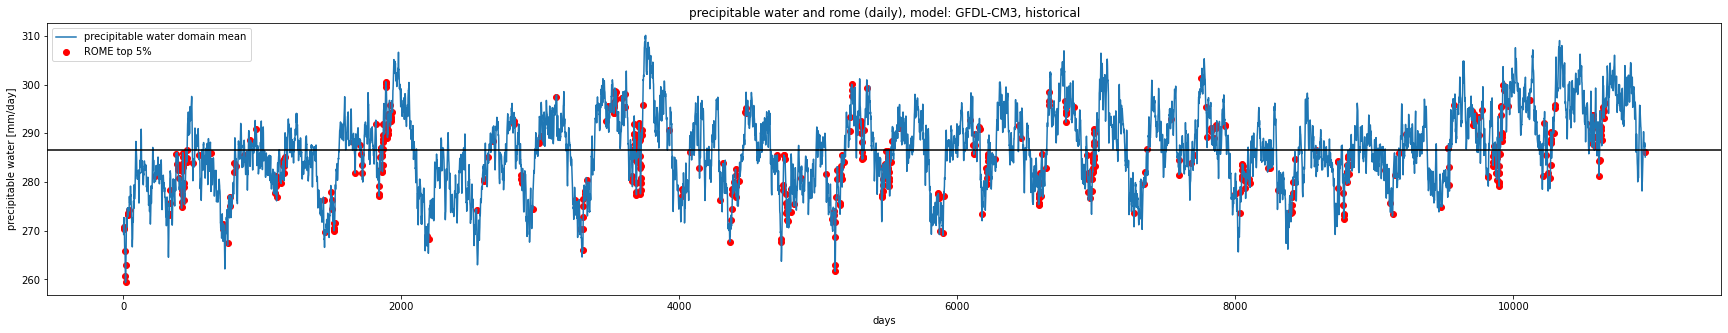

In [17]:
f, ax = plt.subplots(figsize = (30,5))

y = pw.weighted(aWeights).mean(dim=('lat','lon')).data
x= np.arange(0,len(y),1)
rome_prctile = np.percentile(rome[rome_option],95)
x2= np.argwhere(rome[rome_option].data>=rome_prctile)

ax.plot(x,y, label='precipitable water domain mean')
ax.scatter(x2,y[x2],label='ROME top 5%', color='r')
ax.axhline(y=np.mean(y), color='k')
ax.set_title('precipitable water and ' + rome_option + ' (daily), model: ' + model + ', ' + experiment)
ax.set_xlabel('days')
ax.set_ylabel('precipitable water [mm/day]')
ax.legend()

In [18]:
# pw_sMean = pw.weighted(aWeights).mean(dim=('lat','lon'))
# pw_sMean

# import xrft
# pw_fourier = xrft.dft(pw_sMean, dim='time', shift=False)
# power_spectrum = (pw_fourier*pw_fourier.conj()).real
# plt.plot(frequency[1:], power_spectrum[1:])
# plt.xlabel('Frequency [cycles per day]')
# plt.ylabel('Power')
# np.sort(power_spectrum)[-5:]

# data = pw_sMean.values
# fft = np.fft.fft(data)
# psd = np.abs(fft)**2

# plt.plot(psd)
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('Power Spectrum')

# def detrend_dim(da, dim, deg=1):
#     # detrend along a single dimension
#     p = da.polyfit(dim=dim, deg=deg)
#     fit = xr.polyval(dim, p.polyfit_coefficients)
#     return da - fit

# def detrend(da, dims, deg=1):
#     # detrend along multiple dimensions
#     # only valid for linear detrending (deg=1)
#     da_detrended = da
#     for dim in dims:
#         da_detrended = detrend_dim(da_detrended, dim, deg=deg)
#     return da_detrended

### in ascent and descent regions

In [19]:
folder = '/Users/cbla0002/Documents/data/cmip5/ds'
fileName = model + '_wap_' + experiment + '.nc'
path = folder + '/' + fileName
ds = xr.open_dataset(path)
wap500 = ds.wap.sel(plev=500e2)
wap500

<xarray.DataArray 'wap' (time: 10950, lat: 36, lon: 144)>
[56764800 values with dtype=float32]
Coordinates:
    plev     float64 5e+04
  * lat      (lat) float64 -35.0 -33.0 -31.0 -29.0 -27.0 ... 29.0 31.0 33.0 35.0
  * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * time     (time) object 1970-01-01 12:00:00 ... 1999-12-31 12:00:00
Attributes:
    interp_method:     conserve_order2
    units:             Pa s-1
    long_name:         wap
    cell_methods:      time: mean
    valid_range:       [100. 350.]
    standard_name:     lagrangian_tendency_of_air_pressure
    original_units:    Pa/s
    original_name:     wap
    cell_measures:     area: areacella
    associated_files:  baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation...

In [20]:
plot_snapshot(pw.isel(time=0).where(wap500.isel(time=0)>0, np.nan), 'Greens', 'precipitable water in descending regions', model)

ValueError: indexes along dimension 'lat' are not equal